In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# My code
import fast_gillespie as fg


In [2]:
def color_connected_components(G):
    # Get connected components
    components = list(nx.weakly_connected_components(G))
    
    # Generate a list of distinct colors
    colors = 0.8*plt.cm.rainbow(np.linspace(0, 1, len(components)))
    colors[:,3] = 1.0
    np.random.shuffle(colors)
    
    # Create a dictionary mapping each node to its color
    color_map = {}
    for component, color in zip(components, colors):
        for node in component:
            color_map[node] = color
    
    return [color_map[node] for node in G.nodes()]

def plot_state(ax, particle, interaction, k=0.2, node_size=30):
    
    # Create a graph
    G = nx.DiGraph()
    
    # Add connected nodes
    G.add_edges_from(interaction.indices)
    
    # Add monomer nodes
    particle_field_indices = set(i[0] for i in particle.indices)
    interaction_indices = set(i[0] for i in interaction.indices) | set(i[1] for i in interaction.indices)
    monomer_indices = particle_field_indices - interaction_indices
    G.add_nodes_from(monomer_indices)
    
    # Use spring_layout with custom parameters
    pos = nx.spring_layout(G, k=k, iterations=50)
    
    # Get colors for nodes based on their connected component
    node_colors = color_connected_components(G)
    
    # Draw the graph
    nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=node_size, arrowstyle='->', ax=ax)
    
    # Annotate the plot
    ax.set_title("Homopolymer system state")

In [26]:
# Define linear homopolymer

# Create fields
A = fg.Field(name='A', index_dim=1)
a = fg.Field(name='a', index_dim=1)
I = fg.Field(name='I', index_dim=2)

mean_num_monomers = 100.0
mean_num_interactions = 50.0

# Create rules
R_1 = fg.MonomerCreationRule(name='R_1', 
                             rate=mean_num_monomers, 
                             particle=A, 
                             sites=[a])
R_2 = fg.MonomerAnnihilationRule(name='R_2', 
                                 rate=1.0, 
                                 particle=A, 
                                 sites=[a])
R_3 = fg.HomotypicInteractionCreationRule(name='R_3', 
                                          rate=mean_num_interactions/(mean_num_monomers*(mean_num_monomers-1)/2), 
                                          A=A, a=a, I=I)
R_4 = fg.HomotypicInteractionAnnihilationRule(name='R_4', 
                                              rate=1.0, 
                                              A=A, a=a, I=I)       

# Define fock space and rules
space = fg.FockSpace(fields=[A, a, I])
rules = fg.RuleSet(rules=[R_1, R_2, R_3, R_4])

def summary_stats_func():
    particle_field_indices = set(i[0] for i in A.indices)
    interaction_indices = set(i[0] for i in I.indices) | set(i[1] for i in I.indices)
    monomer_indices = particle_field_indices - interaction_indices
    stats_dict = dict(
        num_A=len(A.indices),
        num_I=len(I.indices),
        num_M=len(monomer_indices),
    )
    return stats_dict

In [29]:
def show_sim_stats(sim):
    
    # Create a figure
    fig = plt.figure(figsize=(16,8))
    
    # Create a GridSpec with 2 rows and 2 columns
    gs = gridspec.GridSpec(4, 2)
    
    step_num = np.array([d["step_num"] for d in sim.step_info])   
    rule_num = np.array([d["rule_num"] for d in sim.step_info])
    update_duration = np.array([d["update_duration"] for d in sim.step_info])
    rest_duration = np.array([d["rest_duration"] for d in sim.step_info])
    usr_arrays = []
    for 
    num_A = np.array([d["num_A"] for d in sim.step_info])  
    num_I = np.array([d["num_I"] for d in sim.step_info])  
    num_M = np.array([d["num_M"] for d in sim.step_info])  
    rule_probs = np.array([d["rule_probs"] for d in sim.step_info])
    eligible_rates = np.array([d["eligible_rates"] for d in sim.step_info])
    
    ax = fig.add_subplot(gs[:, 0])
    plot_state(ax=ax, particle=A, interaction=I, k=0.2, node_size=30)
    ax.set_title(f"Homopolymer system after {sim.num_steps:,d} steps")
    
    ax = fig.add_subplot(gs[0, 1])
    ax.plot(step_num, update_duration, label='update')
    ax.plot(step_num, rest_duration, label='rest')
    ax.legend()
    ymax = np.mean(update_duration) + 3*np.std(update_duration)
    ax.set_ylim(0, ymax)
    ax.set_xlim(0, sim.num_steps)
    ax.set_ylabel('duration (s)')
    
    ax = fig.add_subplot(gs[1, 1])
    ax.plot(step_num, num_A, label='num A')
    ax.plot(step_num, num_I, label='num I')
    ax.plot(step_num, num_M, label='num M')
    ax.set_xlim(0, sim.num_steps)
    ax.set_ylabel('number')
    ax.legend(loc='upper right')
    
    ax = fig.add_subplot(gs[2, 1])
    for i in range(4):
        ax.plot(step_num, rule_probs[:, i], label=rules.rules[i].name)
    ax.set_xlim(0, sim.num_steps)
    ax.set_ylim(0, 1)
    ax.set_ylabel('probability')
    ax.set_xlabel('step number')
    ax.legend(loc='upper right')
    
    ax = fig.add_subplot(gs[3, 1])
    for i in range(4):
        ax.plot(step_num, eligible_rates[:, i], label=rules.rules[i].name)
    ax.set_xlim(0, sim.num_steps)
    ax.set_ylabel('eligible rate')
    ax.set_xlabel('step number')
    ax.legend(loc='upper right')


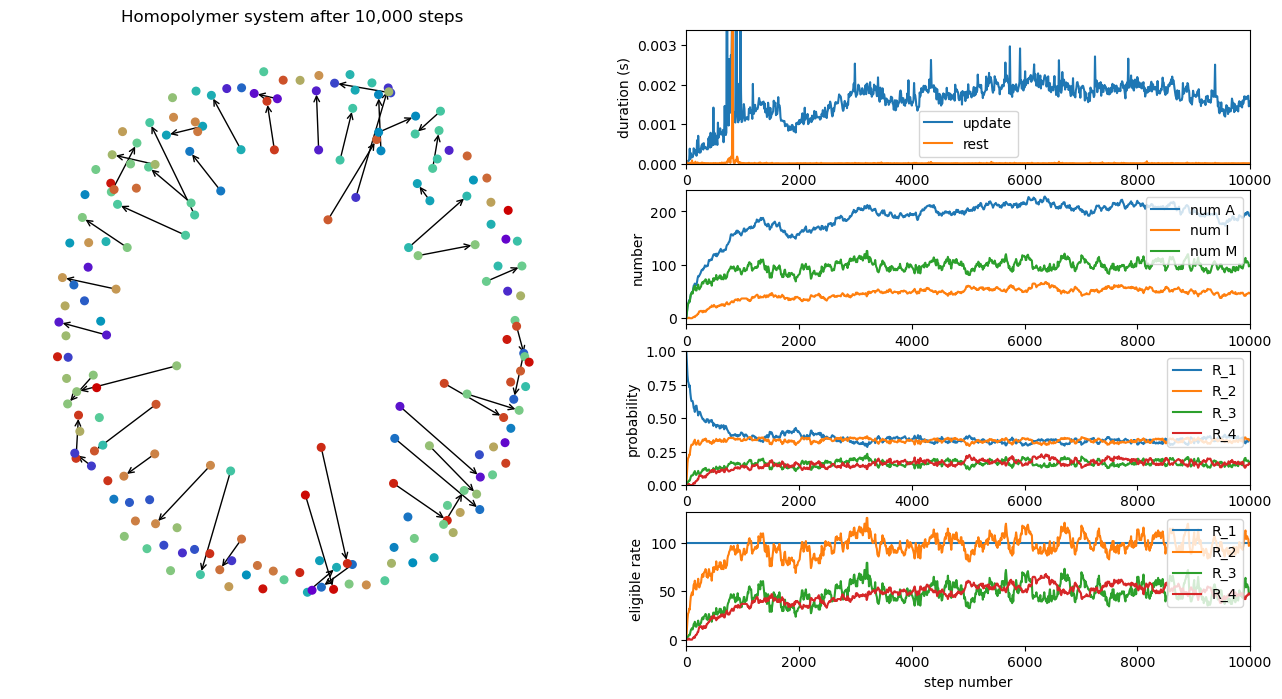

In [30]:
# Define, initialize, and run simulation
sim = fg.Simulation(space=space, rules=rules, custom_stats_func=summary_stats_func)
sim.initialize_state()
sim.run(num_steps=10000, record_every=10)

show_sim_stats(sim)